# 1 epoch Training with PyTorch

In [51]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

valid = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [52]:
import torch

if torch.cuda.is_available():
    tensor = tensor.to("cuda")

In [53]:
def class_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [54]:
from torch.utils.data import DataLoader

bs=64
train_dl = DataLoader(train, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid, batch_size=bs, shuffle=True)

In [55]:
image, label = next(iter(train_dl))

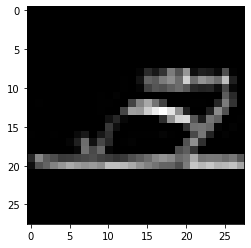

In [56]:
import matplotlib.pyplot as plt

plt.imshow(image[0].squeeze(), cmap='gray')

In [57]:
class_label(label[0])

'Sandal'

### Linear

In [58]:
import torch.nn as nn

class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        
        
    def forward(self, x):
        x = self.flatten(x)
        out = self.layers(x)
        return out

In [59]:
model = Model()

In [60]:
import torch.nn.functional as F

loss_func = F.cross_entropy

In [61]:
from torch import optim

lr=0.001
optimizer = optim.SGD(model.parameters(), lr=lr)

In [62]:
model

Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [63]:
def accuracy(out, y_batch): 
    return (torch.argmax(out, dim=1)==y_batch).float().mean()

In [64]:
from torch.autograd import Variable

def fit(epochs=1, model=model, loss_func=loss_func, optimizer=optimizer, train_dl=train_dl, valid_dl=valid_dl):
    
    print("Model:\n", model)
    
    for epoch in range(epochs):
        model.train()
#         print(model.training)
        
        for x_batch, y_batch in train_dl:
            predictions = model(x_batch)
            loss = loss_func(predictions, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        model.eval()
#         print(model.training)
        
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for x_batch, y_batch in valid_dl:
                predictions = model(x_batch)
                tot_loss += loss_func(predictions, y_batch)
                tot_acc += accuracy(predictions, y_batch)
        
        print(epoch, tot_loss/len(valid_dl), tot_acc/len(valid_dl))
        
    return tot_loss/len(valid_dl), tot_acc/len(valid_dl)

In [65]:
optimizer = optim.SGD(model.parameters(), lr=lr)
%time fit(epochs=1, model=model, loss_func=loss_func, optimizer=optimizer, train_dl=train_dl, valid_dl=valid_dl)

Model:
 Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
0 tensor(1.7984) tensor(0.6246)
CPU times: user 19.2 s, sys: 25 ms, total: 19.2 s
Wall time: 9.61 s


(tensor(1.7984), tensor(0.6246))

### Leaky ReLU

In [66]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 10),
        )
        
        
    def forward(self, x):
        x = self.flatten(x)
        out = self.layers(x)
        return out

In [67]:
model = Model()
optimizer = optim.SGD(model.parameters(), lr=lr)
%time fit(epochs=1, model=model, loss_func=loss_func, optimizer=optimizer, train_dl=train_dl, valid_dl=valid_dl)

Model:
 Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
0 tensor(1.7537) tensor(0.6345)
CPU times: user 19.5 s, sys: 24.2 ms, total: 19.5 s
Wall time: 9.9 s


(tensor(1.7537), tensor(0.6345))

### Convolution

In [68]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
          )
        
        self.fc = nn.Linear(in_features=6400, out_features=10) 

    def forward(self, x):
        out = self.layer(x)
        out = torch.flatten(out, 1)
        out = F.leaky_relu(self.fc(out), 0.2)
        return out

In [69]:
model = Model()
optimizer = optim.SGD(model.parameters(), lr=lr)
%time fit(epochs=1, model=model, loss_func=loss_func, optimizer=optimizer, train_dl=train_dl, valid_dl=valid_dl)

Model:
 Model(
  (layer): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  )
  (fc): Linear(in_features=6400, out_features=10, bias=True)
)
0 tensor(0.7628) tensor(0.7144)
CPU times: user 36.5 s, sys: 67.2 ms, total: 36.6 s
Wall time: 18.3 s


(tensor(0.7628), tensor(0.7144))

### Convolution with `torch.nn.MaxPool2d`

In [70]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2)
          )
        
        self.fc = nn.Linear(in_features=1600, out_features=10) 

    def forward(self, x):
        out = self.layer(x)
        out = torch.flatten(out, 1)
        out = F.leaky_relu(self.fc(out), 0.2)
        return out

In [71]:
model = Model()
optimizer = optim.SGD(model.parameters(), lr=lr)
%time fit(epochs=1, model=model, loss_func=loss_func, optimizer=optimizer, train_dl=train_dl, valid_dl=valid_dl)

Model:
 Model(
  (layer): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1600, out_features=10, bias=True)
)
0 tensor(0.9899) tensor(0.6632)
CPU times: user 39.2 s, sys: 68.5 ms, total: 39.2 s
Wall time: 19.7 s


(tensor(0.9899), tensor(0.6632))

### Convolution with Dropout

In [72]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2)
          )
        
        self.fc1 = nn.Linear(in_features=1600, out_features=1024)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=1024, out_features=10) 

    def forward(self, x):
        out = self.layer(x)
        out = torch.flatten(out, 1)
        out = F.leaky_relu(self.fc1(out), 0.2)
        out = self.drop(out)
        out = F.leaky_relu(self.fc2(out), 0.2)
        return out

In [73]:
model = Model()
optimizer = optim.SGD(model.parameters(), lr=lr)
%time fit(epochs=1, model=model, loss_func=loss_func, optimizer=optimizer, train_dl=train_dl, valid_dl=valid_dl)

Model:
 Model(
  (layer): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1600, out_features=1024, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)
0 tensor(2.1385) tensor(0.5400)
CPU times: user 55.6 s, sys: 106 ms, total: 55.7 s
Wall time: 27.9 s


(tensor(2.1385), tensor(0.5400))

### Optimising model for `epochs=1` with `BatchNorm2d`

In [74]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = F.leaky_relu(self.fc1(out), 0.2)
        out = self.drop(out)
        out = F.leaky_relu(self.fc2(out), 0.2)
        
        return out

In [75]:
model = Model()
optimizer = optim.SGD(model.parameters(), lr=lr)
%time fit(epochs=1, model=model, loss_func=loss_func, optimizer=optimizer, train_dl=train_dl, valid_dl=valid_dl)

Model:
 Model(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=10, bias=True)
)
0 tensor(0.7885) tensor(0.7809)
CPU times: user 1min 41s, sys: 1.26 s, total: 1min 42s
Wall time: 51.4 s


(tensor(0.7885), tensor(0.7809))

In [76]:
fit(epochs=10, model=model, loss_func=loss_func, optimizer=optimizer, train_dl=train_dl, valid_dl=valid_dl)

Model:
 Model(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=10, bias=True)
)
0 tensor(0.6208) tensor(0.8159)
1 tensor(0.5503) tensor(0.8346)
2 tensor(0.5090) tensor(0.8468)
3 tensor(0.4770) tensor(0.8541)
4 tensor(0.4520) tensor(0.8617)
5 tensor(0.4361) tensor(0.8645)
6 tensor(0.4220) tensor(0.8678)
7 tensor(0.4052) tensor(0

(tensor(0.3874), tensor(0.8769))

### Best performing classes

In [77]:
classes = [
    'Top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot'
]

In [80]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in train_dl:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Top   is 87.4 %
Accuracy for class: Trouser is 97.0 %
Accuracy for class: Pullover is 81.5 %
Accuracy for class: Dress is 91.1 %
Accuracy for class: Coat  is 83.7 %
Accuracy for class: Sandal is 96.1 %
Accuracy for class: Shirt is 66.2 %
Accuracy for class: Sneaker is 94.8 %
Accuracy for class: Bag   is 96.6 %
Accuracy for class: Ankle Boot is 95.3 %
